<a href="https://colab.research.google.com/github/waterfogSW/cover_set/blob/master/ipynb_file/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
def parse_csv(path : str):
    scp_df = pd.read_csv(path)
    scp_df = scp_df.rename(columns={'X0':'X'})
    scp_df = scp_df.rename(columns={'X1':'Y'})
    return scp_df

In [3]:
df = parse_csv("./scp_data.csv")
df.head()

,X,Y
0,-6.810625,-0.060347
1,-0.303414,-2.979659
2,-7.891267,-11.736160
3,4.327531,2.606615
4,-9.171777,-6.358040


In [4]:
# normalize data
loc = df.values
sc = StandardScaler()
sc.fit(loc)
loc = sc.transform(loc)

In [5]:
def kmeans(loc,k=3,max_iterations=100):
    '''
    loc: Police office location data
    k: number of clusters
    max_iterations: number of repetitions before clusters are established
    '''
    if isinstance(loc, pd.DataFrame):loc = loc.values
    idx = np.random.choice(len(loc), k, replace=False)
    centroids = loc[idx, :]
    P = np.argmin(distance.cdist(loc, centroids, 'euclidean'),axis=1)
    for _ in range(max_iterations):
        centroids = np.vstack([loc[P==i,:].mean(axis=0) for i in range(k)])
        tmp = np.argmin(distance.cdist(loc, centroids, 'euclidean'),axis=1)
        if np.array_equal(P,tmp):break
        P = tmp
    return P

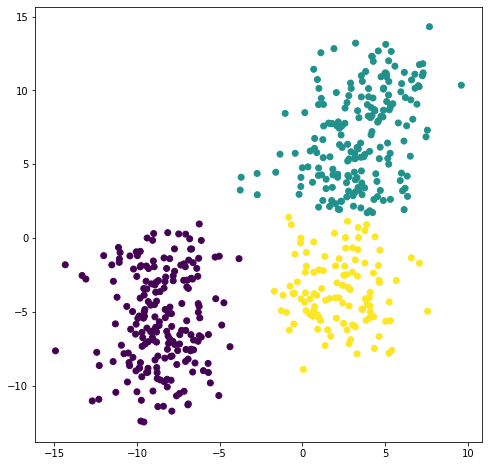

In [7]:
cluster_num = 3
P = kmeans(loc,cluster_num)

assert len(df) == len(P)
# denormalize data
loc = sc.inverse_transform(loc)
plt.subplots(figsize=(8, 8))
plt.scatter(loc[:,0],loc[:,1],c=P)
plt.show()

In [8]:
cluster = pd.DataFrame(P, columns = ['cluster'])
df['cluster'] = cluster
df.head()

,X,Y,cluster
0,-6.810625,-0.060347,0
1,-0.303414,-2.979659,2
2,-7.891267,-11.736160,0
3,4.327531,2.606615,1
4,-9.171777,-6.358040,0


In [9]:
groups = df.groupby(df.cluster)
df_arr = []
for i in range(0, cluster_num):
    df_arr.append(groups.get_group(i))
 

In [10]:
df_arr[0]

,X,Y,cluster
0,-6.810625,-0.060347,0
2,-7.891267,-11.736160,0
4,-9.171777,-6.358040,0
7,-7.476478,0.270167,0
8,-6.728764,-2.734686,0
...,...,...,...
491,-6.575376,-7.582890,0
492,-6.892457,-3.420081,0
494,-5.983171,-8.993865,0
497,-4.374134,-7.369407,0


In [33]:
import math

def isInCircle(Cx, Cy, Px, Py, radius : int):
    dist = math.sqrt((Cx-Px)**2 + (Cy-Py)**2)
    if dist <= radius:
        return True
    else:
        return False
# 각 점을 중심점 삼아 'radius'길이의 반지름을 갖는 원을 생성한다. 
# 생성된 원은 _circle 리스트에 전달(각 원은 리스트 형태이고, 원 안의 점들(인덱스)이 포함된다.)
def make_circle(ax, ay, data, radius):
    _info = []
    _info.append([ax, ay])
    _circle = []
    
    for idx in range(data['X'].size):
        bx = data.values[idx][0]
        by = data.values[idx][1]
        
        if(isInCircle(ax, ay, bx, by, radius)):
            #if ax == bx and ay == by:  # 중심점 제외
            #    continue
            _circle.append(idx)
           
    _info.append(_circle)
    
    return _info, len(_circle) # 원 안의 요소들 집합과 원의 사이즈 리턴

def make_total_circle(radius, data):
    totalCircle = []
    totalCircleSize = []
    for idx in range(data['X'].size):
        ax = data.values[idx][0]
        ay = data.values[idx][1]
    
        _circle, _circleSize = make_circle(ax, ay, data, radius)
        totalCircle.append(_circle)
        totalCircleSize.append(_circleSize)
    
    return totalCircle

# 합집합 갱신 
def update_unionSet(totalSelectedPoint, unionSet, selectedPoint):
    totalSelectedPoint.append(selectedPoint[0])
    unionSet += selectedPoint[1]
    
    return totalSelectedPoint, unionSet

# 데이터 갱신(이미 선택된 점들 제거)
def update_data(unionSet, totalCircle,data): ## 변경
    newTotalCircle = []
    unionSet = set(unionSet)
    
    for idx in range(len(data)): ## 변경
        tempSet = set(totalCircle[idx][1])
        
        tempSet = tempSet - unionSet
        tempSet = list(tempSet)
        
        _temp = [] 
        _temp.append(totalCircle[idx][0])
        _temp.append(tempSet)
        
        newTotalCircle.append(_temp)
        
    return newTotalCircle

# 최적의 중심점들을 도출
def processing(totalCircle, data): ## 변경
    unionSet = []
    totalSelectedPoint = []
    
    while len(unionSet) < len(data): ## 변경
        # sort
        totalCircle.sort(key = lambda x:len(x[1]), reverse=True)
        
        # 가장 큰 집합 선택
        selectedPoint = totalCircle[0]
        
        # 좌표 append, 합집합 갱신
        totalSelectedPoint, unionSet = update_unionSet(totalSelectedPoint, unionSet, selectedPoint)
        
        # 처음 좌표의 리스트 기준으로 나머지 리스트 갱신
        totalCircle = update_data(unionSet, totalCircle, data)
        
        
    return totalSelectedPoint

# 시각화
def scatter_circles(selected_point, radius, data):

    fig, ax_nstd = plt.subplots(figsize=(8, 8))

    plt.scatter(data['X'],data['Y'], s=5, alpha=0.7, c=P) ## 변경
    for Cx, Cy in selected_point:
        plt.scatter(Cx, Cy, color = 'k', marker = 'x', s = 10)
        ax_nstd.add_patch(plt.Circle((Cx, Cy), radius, color='lavender', alpha=0.3))
    plt.show()

def  c_cover_set_test(start, end, path) :
    data = parse_csv(path)
    for radius in range(start, end):
        totalSelectedPoint = []
        for i in range(cluster_num):
            totalCircle = make_total_circle(radius,df_arr[i])
            SelectedPoint = processing(totalCircle,df_arr[i])
            totalSelectedPoint = totalSelectedPoint + SelectedPoint
        print ("반지름 길이: {radius}인 원 생성, 선택된 점들".format(radius=radius))
        print(totalSelectedPoint)

        scatter_circles(totalSelectedPoint, radius, data)
        print("선택된 원의 갯수: {num}".format(num=len(totalSelectedPoint)))
        print("\n\n")

반지름 길이: 3인 원 생성, 선택된 점들
[[-8.010849784678102, -6.850366440142776], [-8.959881679987337, -1.954042004858892], [-10.000137822905048, -10.425973359602867], [-6.632172595724741, -9.08632540183337], [-6.605503110707942, -1.6807244277222984], [-11.425554452845542, -2.938408825373928], [-12.281305912234053, -8.64686704463743], [-5.235974902635094, -4.119357783095237], [-11.52250263011322, -1.8271859527260117], [2.8216352846256663, 4.136913495172196], [4.902193048990443, 10.084446430105672], [1.0026573338898048, 10.133946904149617], [6.527121501791578, 5.539298778677661], [-1.6090987939367123, 4.4484997098738965], [5.373740422273478, 12.636983164866734], [7.081399420875013, 11.73787445447032], [-1.3502767499896633, 5.675071460003122], [4.442232623672101, 4.345441011891947], [2.0097604567262604, -4.058358305114123], [1.9397566905945585, 0.314399491924696], [5.036332198569792, -5.64464495166971], [-0.7899674747110494, -6.245615220364826], [5.6764496868279695, -2.877536152890145]]


NameError: ignored

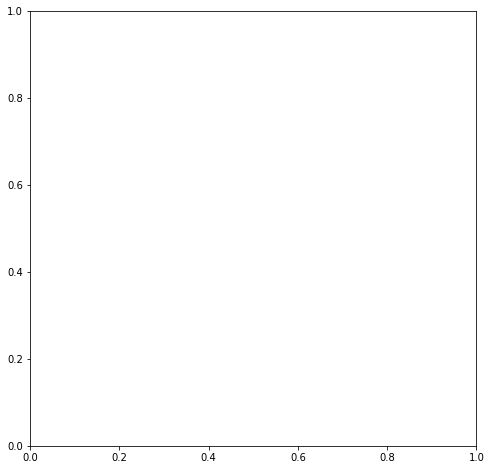

In [32]:
c_cover_set_test(3,15,"scp_data.csv")